In [1]:
from allensdk.brain_observatory.behavior.behavior_project_cache import BehaviorProjectCache as bpc
from visual_behavior.translator.allensdk_sessions import sdk_utils
import visual_behavior.utilities as vbu
import visual_behavior.database as db
import scipy.misc
import os
import imageio

from tqdm import tqdm

import matplotlib.pyplot as plt

/home/dougo/.local/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib notebook
%widescreen

In [3]:
def get_movie_filepath(osid):
    well_known_files = db.get_well_known_files(osid).set_index('name')
    behavior_video_path = ''.join(well_known_files.loc['RawBehaviorTrackingVideo'][['storage_directory', 'filename']].tolist())
    return behavior_video_path

In [4]:
def get_sync_data(osid):
    well_known_files = db.get_well_known_files(osid).set_index('name')
    sync_path = ''.join(well_known_files.loc['OphysRigSync'][['storage_directory', 'filename']].tolist())
    sync_data = vbu.get_sync_data(sync_path)
    return sync_data

In [5]:
manifest_path = "/home/dougo/manifest.json"
cache = bpc.from_lims(manifest=manifest_path)

In [6]:
# predictions_path = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/lick_detection_validation/models/three_class_model'
# predictions = [fn for fn in os.listdir(predictions_path) if fn.endswith('.npz')]
# oeids = []
# for fn in predictions:
#     oeids.append(int(fn.split('oeid=')[1].split('_')[0]))
# oeids

In [80]:
osids = [954408500, 846026867]
oeids = [sdk_utils.get_oeid_from_osid(osid,cache) for osid in osids]
oeids

[956903412, 846490568]

In [81]:
for oeid in oeids:
    osid = sdk_utils.get_osid_from_oeid(oeid, cache)
    print('on oeid {}'.format(oeid))
    try:
        session = cache.get_session_data(oeid)

        sync_data = get_sync_data(osid)

        movie_path = get_movie_filepath(osid)
        movie = vbu.Movie(movie_path,sync_timestamps=sync_data['cam1_exposure_rising'])

        licks = session.licks

        predictions_path = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/lick_detection_validation/models/three_class_model/predictions_oeid={}_osid={}.npz'.format(oeid,osid)
        predictions = np.load(predictions_path)
        lick_preds = predictions['all_preds'][:,2]
        paw_preds = predictions['all_preds'][:,1]

        times = sync_data['cam1_exposure_rising'][:np.shape(predictions['all_preds'])[0]]
        
        likely_false_negative_licks = []
        likely_false_negative_paws = []
        for lick_time in licks['time']:
            idx = np.where(np.logical_and((t>lick_time - 0.1),(t<lick_time+0.05)))
            if np.max(paw_preds[idx[0]]) < 0.9 and np.max(lick_preds[idx[0]]) < 0.9:
                if np.max(paw_preds[idx[0]]) > np.max(lick_preds[idx[0]]):
                    frame = idx[0][np.argmax(paw_preds[idx[0]])]
                    likely_false_negative_paws.append(frame)
                    savepath = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/lick_detection_validation/likely_false_negative_paws'
                    im = movie.get_frame(frame)
                    imageio.imsave(os.path.join(savepath,"oeid_{}__frame_{}.png".format(oeid, frame)),im)
                else:
                    frame = idx[0][np.argmax(lick_preds[idx[0]])]
                    likely_false_negative_licks.append(frame)
                    savepath = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/lick_detection_validation/likely_false_negative_licks'
                    im = movie.get_frame(frame)
                    imageio.imsave(os.path.join(savepath,"oeid_{}__frame_{}.png".format(oeid, frame)),im)
                    
        likely_false_positives = []
        savepath = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/lick_detection_validation/likely_false_positives'
        for predicted_lick_frame in np.random.choice(np.where(np.logical_or(lick_preds>0.1,paw_preds>0.1))[0],1000):
            predicted_lick_time = times[predicted_lick_frame]
            if len(licks.query('time > (@predicted_lick_time - 2) and time < (@predicted_lick_time + 2)')) == 0:
                likely_false_positives.append(predicted_lick_frame)
                im = movie.get_frame(predicted_lick_frame)
                imageio.imsave(os.path.join(savepath,"oeid_{}__frame_{}.png".format(oeid, predicted_lick_frame)),im)
                
    except Exception as e:
        print('failed on {}\n{}'.format(oeid,e))
    


on oeid 956903412
on oeid 846490568


In [50]:
np.max(paw_preds[idx[0]])

0.40204665

<IPython.core.display.Javascript object>


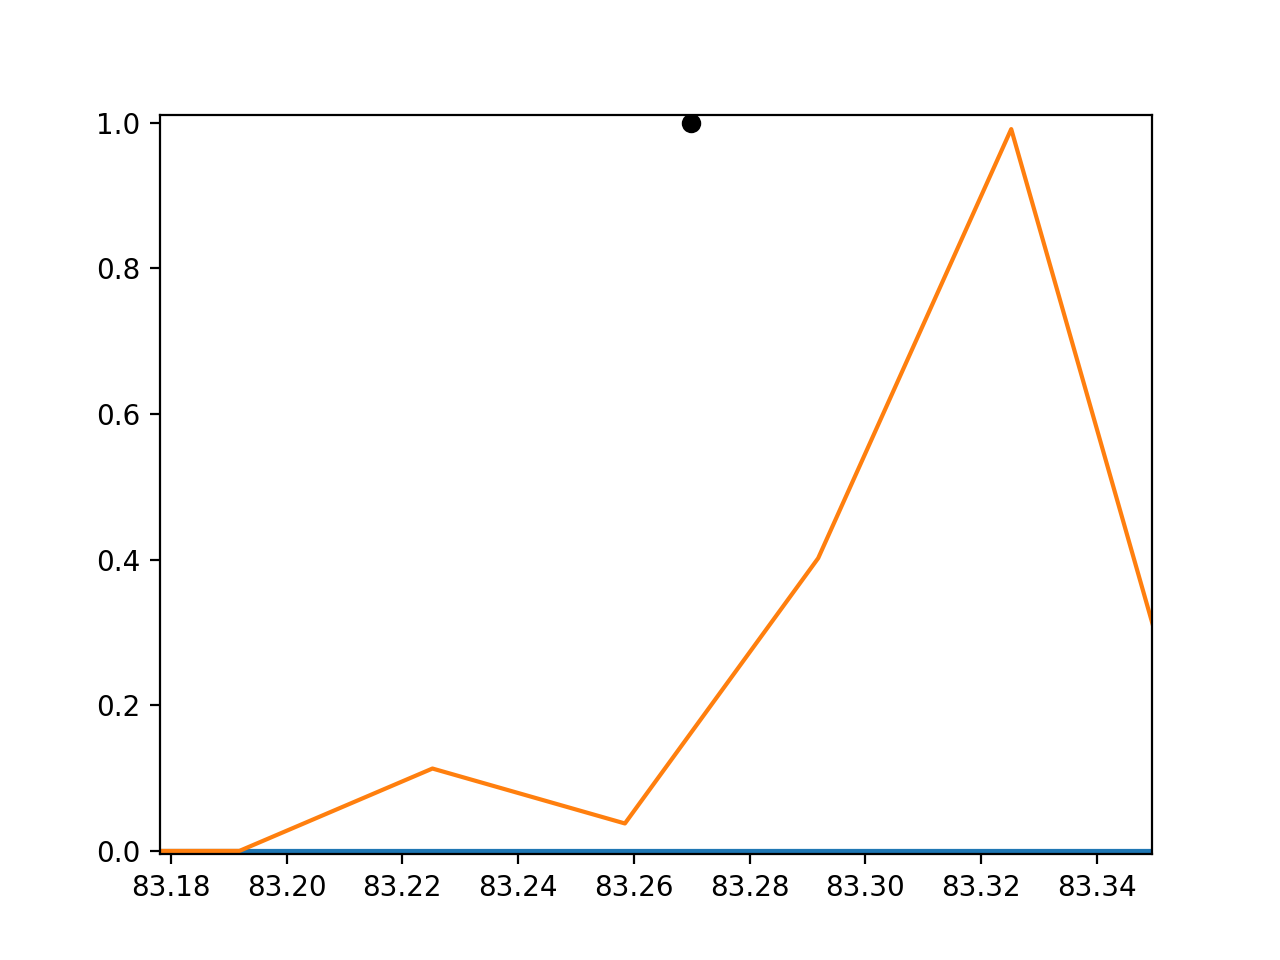

In [13]:
fig,ax=plt.subplots()
ax.plot(sync_data['cam1_exposure_rising'][:np.shape(predictions['all_preds'])[0]],predictions['all_preds'][:,2])

ax.plot(sync_data['cam1_exposure_rising'][:np.shape(predictions['all_preds'])[0]],predictions['all_preds'][:,1])
ax.plot(licks, np.ones_like(licks), 'ok')

<IPython.core.display.Javascript object>


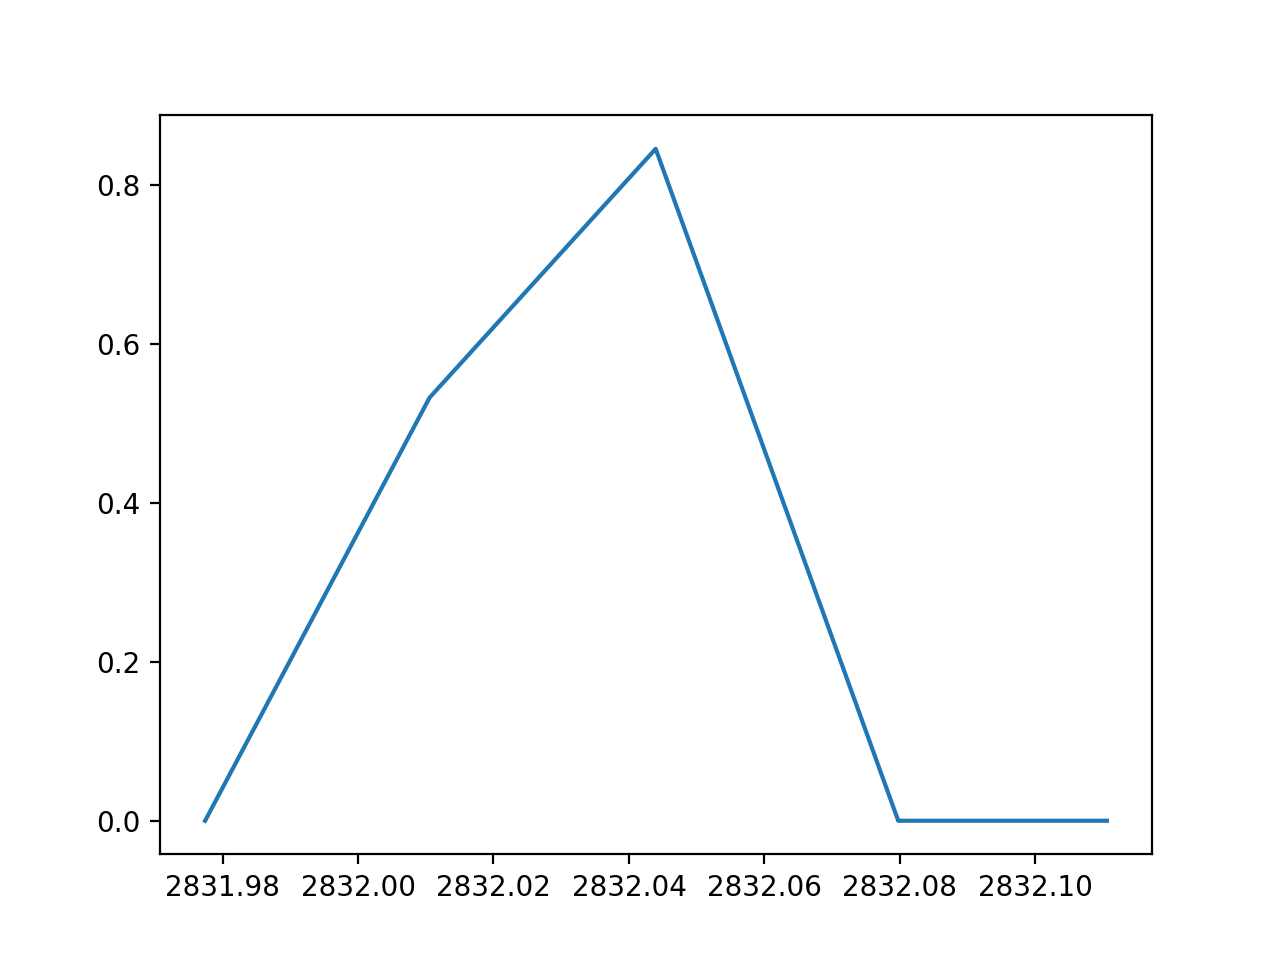

In [23]:
lick = licks.query('time > 2832.02 and time < 2832.09')
lick_time = lick['time'].iloc[0]
t = sync_data['cam1_exposure_rising'][:np.shape(predictions['all_preds'])[0]]
idx = np.where(np.logical_and((t>lick_time - 0.1),(t<lick_time+0.05)))
false_positive_frame = idx[0][np.argmax(predictions['all_preds'][idx[0],2])]


In [26]:
idx[0][np.argmax(predictions['all_preds'][idx[0],2])]

84959

<IPython.core.display.Javascript object>


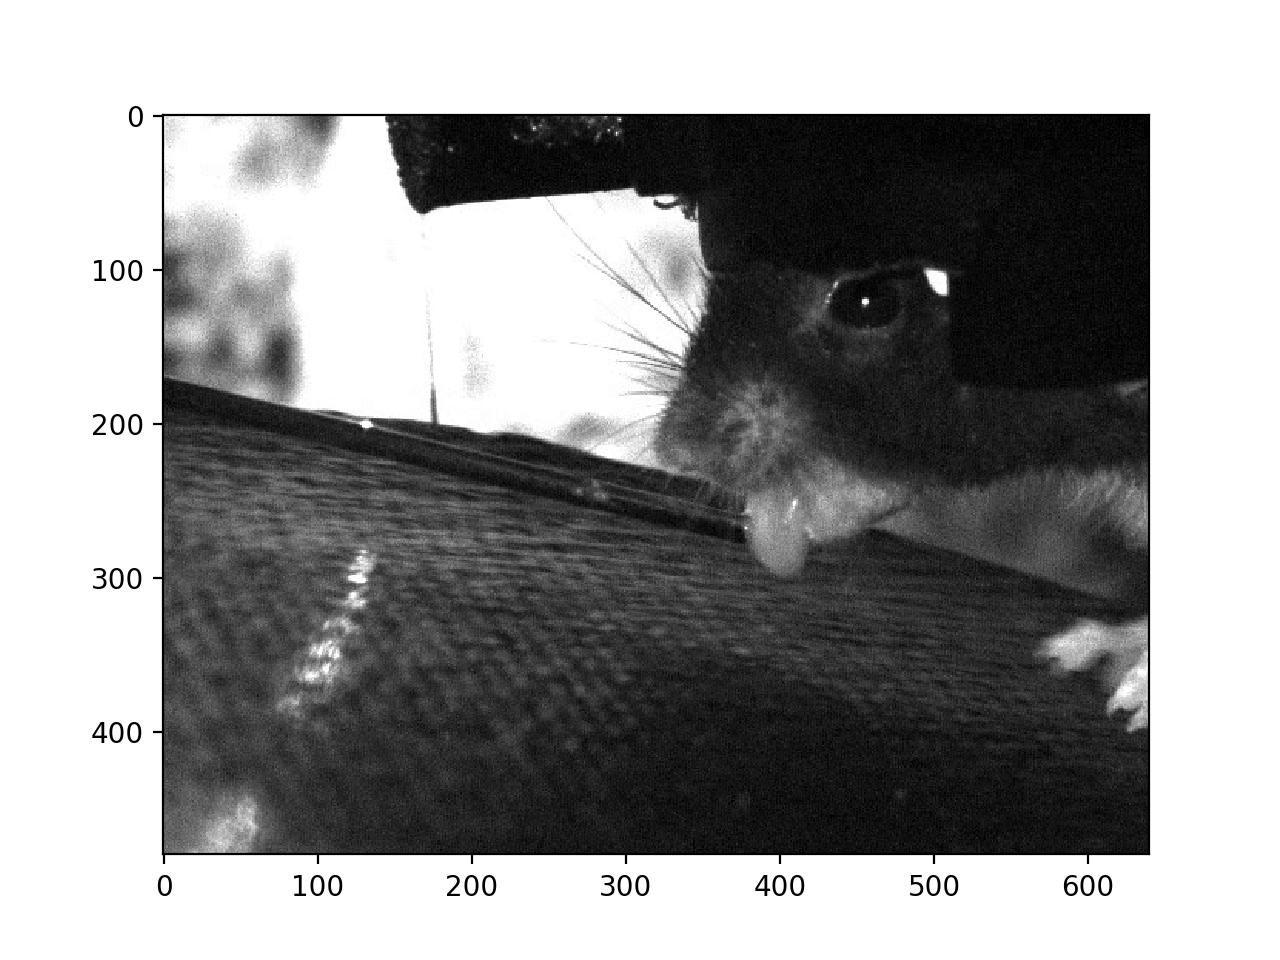

In [78]:
fig,ax=plt.subplots()
ax.imshow(movie.get_frame(likely_false_negative_licks[30]))

In [79]:
%debug

> /home/dougo/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py(86)_wrapreduction()
     84                 return reduction(axis=axis, out=out, **passkwargs)
     85 
---> 86     return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
     87 
     88 

ipdb> q


In [92]:
cache.get_experiment_table().loc[oeid]

ophys_session_id                                                     793870077
behavior_session_id                                                  794093676
container_id                                                         782536745
project_code                                                    VisualBehavior
container_workflow_state                                          container_qc
experiment_workflow_state                                               failed
session_name                                               20181212_403491_7RF
session_type                                       VisCodingTargetedMovieClips
equipment_name                                                         CAM2P.5
date_of_acquisition                                 2018-12-12 16:05:07.000000
isi_experiment_id                                                    730814230
specimen_id                                                          722884882
sex                                                 

In [30]:

len(sync_data['cam1_exposure_rising'])

136114

In [23]:
np.diff(sync_data['cam1_exposure_rising'])

array([0.01627, 0.00261, 0.03322, ..., 0.03008, 0.03314, 0.04157])

In [24]:
predictions['all_preds'][0]

array([9.9920779e-01, 4.6735637e-05, 7.4559369e-04], dtype=float32)

In [37]:
sync_data['cam1_exposure_rising'][:np.shape(predictions['all_preds'])[0]]

array([1.74500000e-01, 1.90770000e-01, 1.93380000e-01, ...,
       4.53708067e+03, 4.53711749e+03, 4.53714757e+03])

In [27]:
np.shape(predictions['all_preds'])

(136112, 3)

<IPython.core.display.Javascript object>


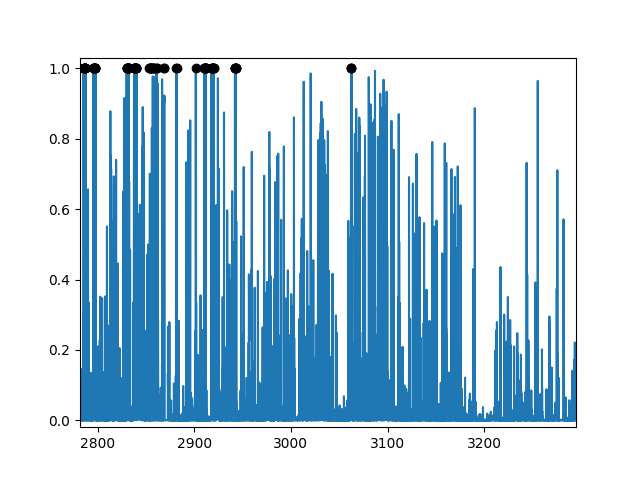

<IPython.core.display.Javascript object>


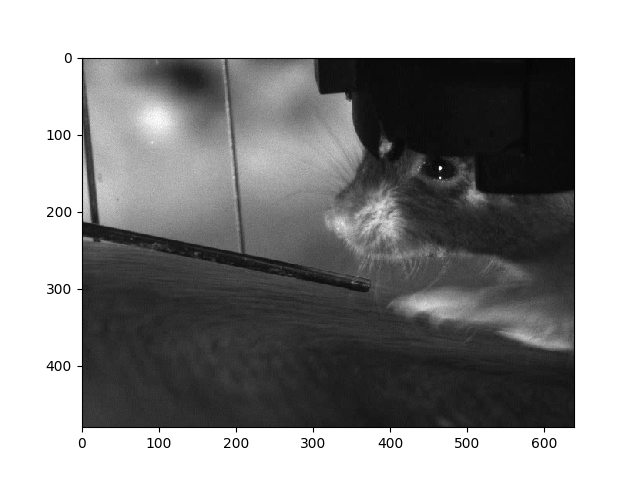

In [65]:
fig,ax=plt.subplots()
ax.imshow(movie.get_frame(likely_false_positives[15]))

KeyboardInterrupt: 

In [70]:
imageio.imsave?

In [38]:
fig,ax=plt.subplots(2,1,figsize=(12,8))
frame = 23

ax[0].cla()
ax[1].cla()

current_time = sync_data['cam1_exposure_rising'][frame]
ax[0].imshow(movie.get_frame(frame))
ax[0].set_title('lick_prob = {:0.4f}'.format(predictions['all_preds'][frame][2]))
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].plot(sync_data['cam1_exposure_rising'][:np.shape(predictions['all_preds'])[0]],predictions['all_preds'][:,2])
ax[1].plot(licks.query('time <= @max_time'), np.ones_like(licks.query('time <= @max_time')), 'ok')
ax[1].set_xlim(current_time-1,current_time+1)
ax[1].axvline(current_time,color='black',linewidth=2)
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('lick probability')

<IPython.core.display.Javascript object>

UndefinedVariableError: local variable 'max_time' is not defined

<IPython.core.display.Javascript object>


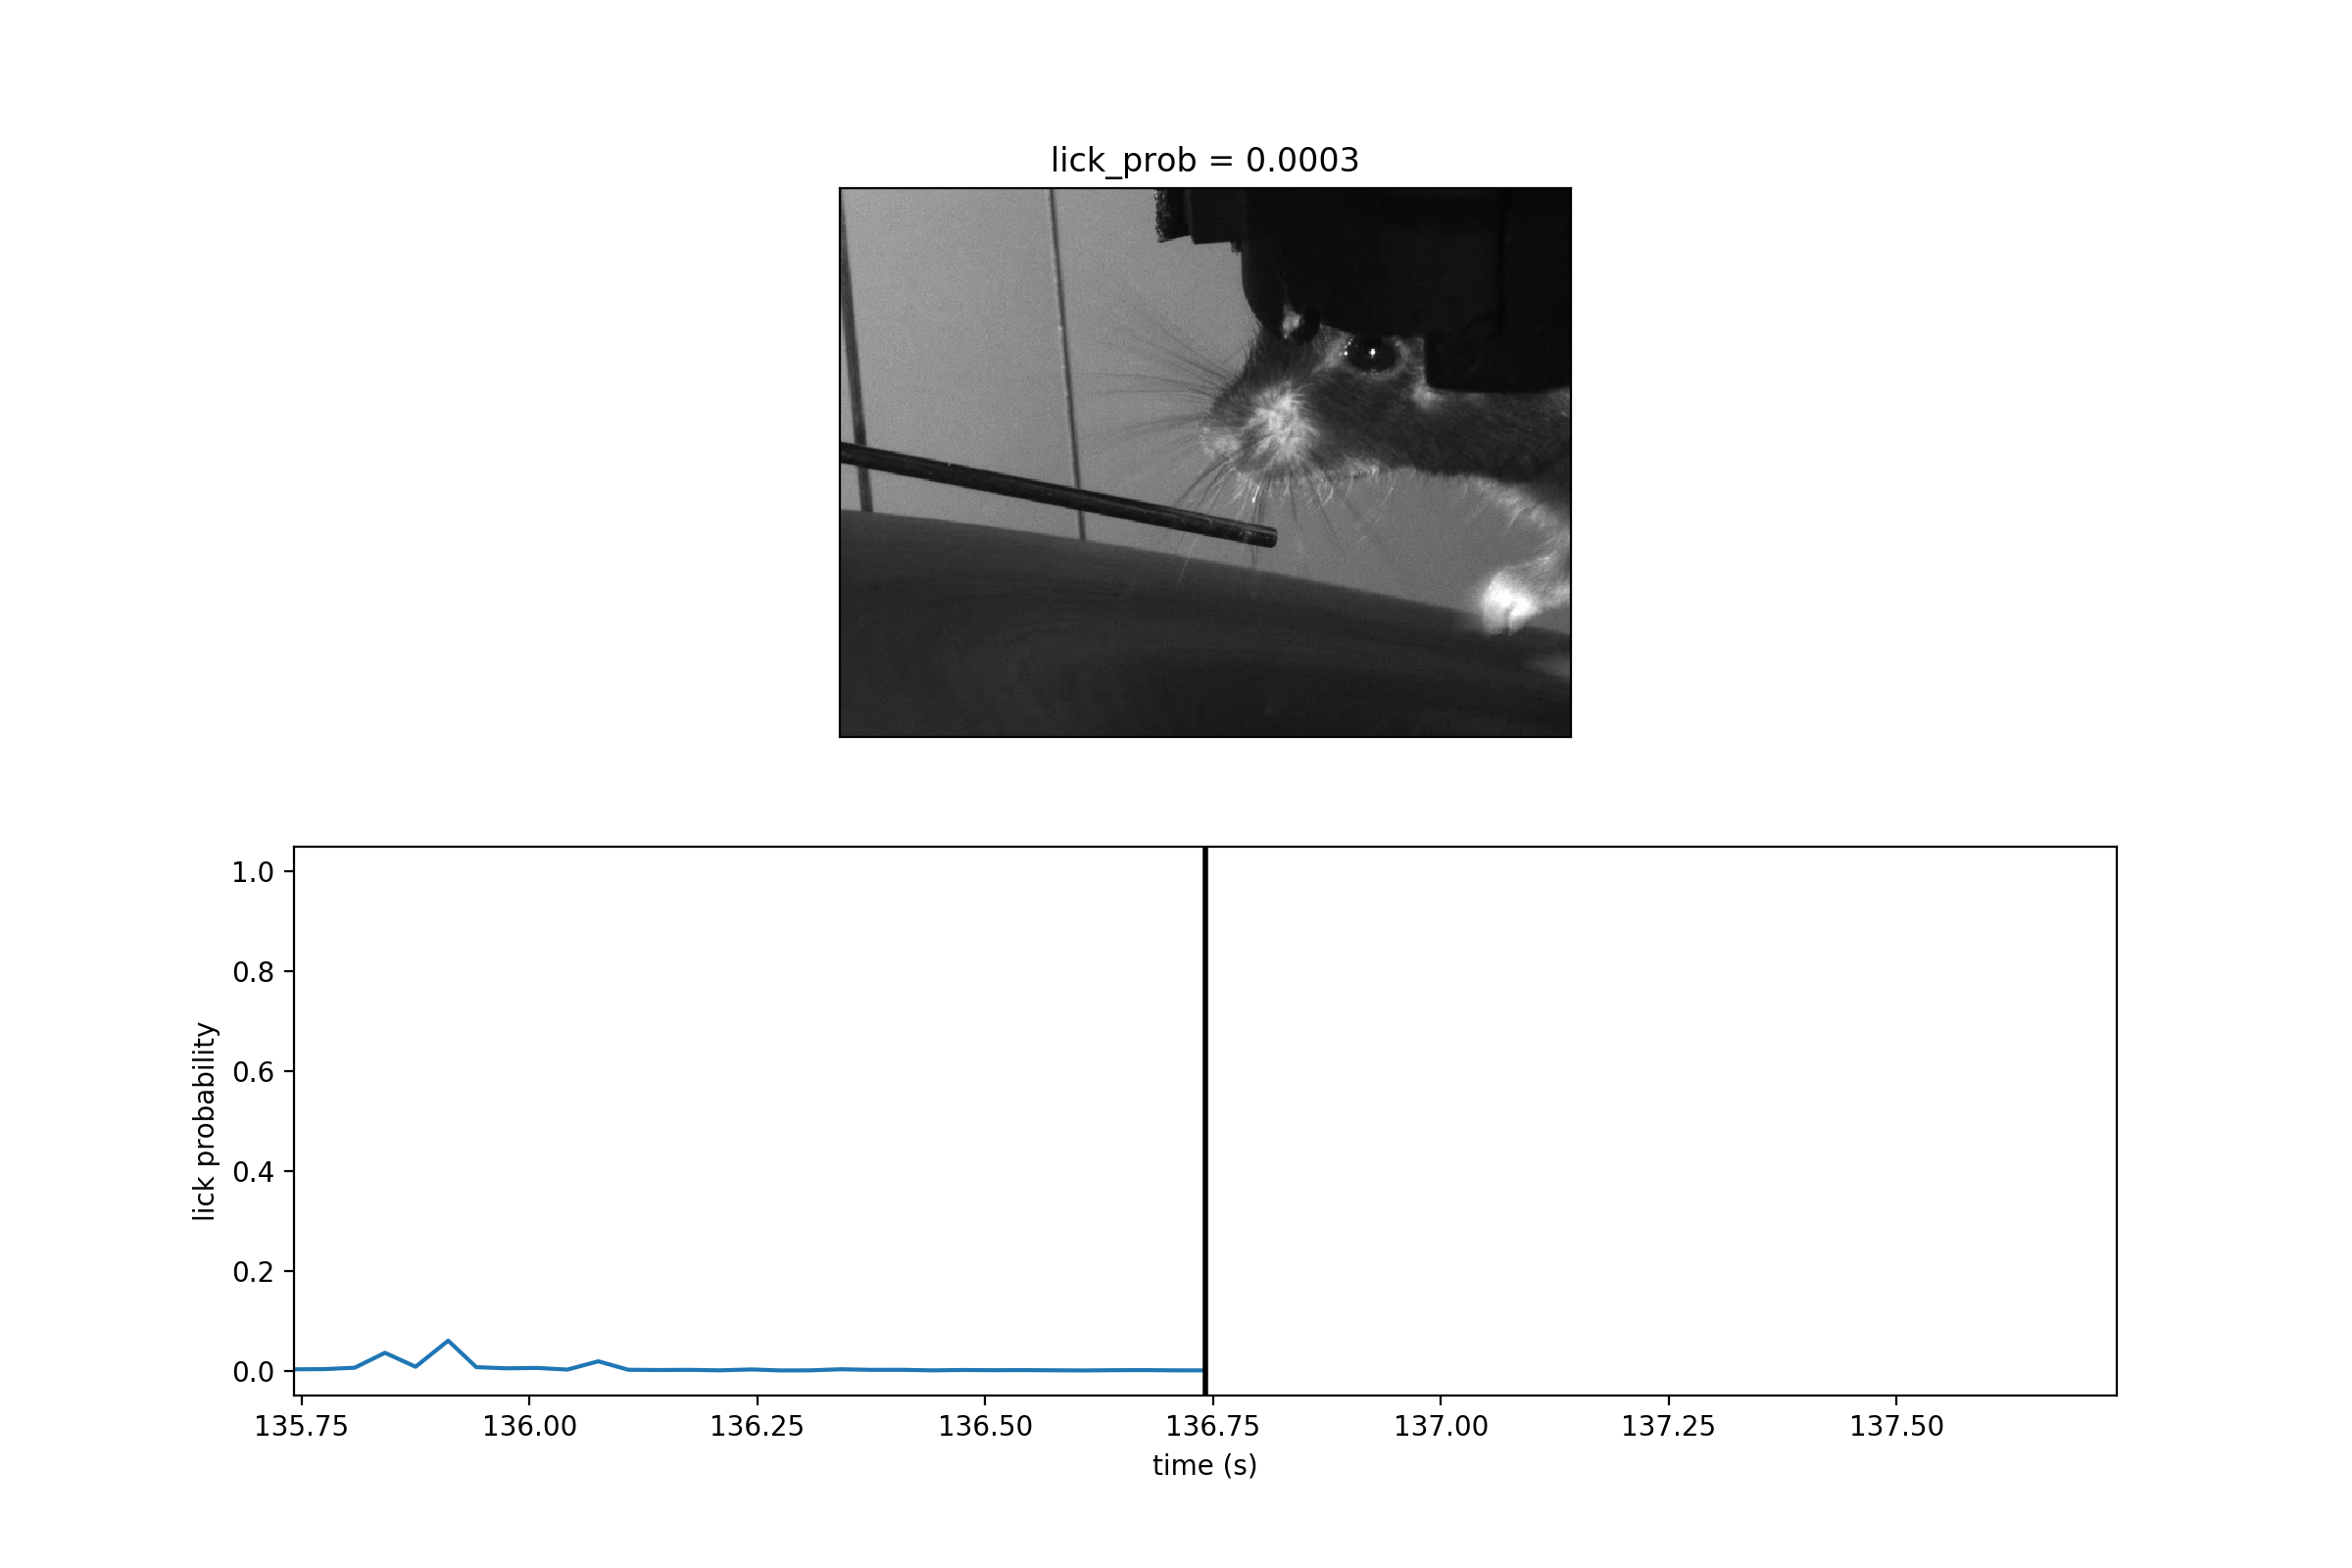

100%|██████████| 4096/4096 [30:57<00:00,  1.69it/s]


In [120]:
save_folder = '/ssd1/lick_detection_model/three_class_model/841948542_frames'
fig,ax=plt.subplots(2,1,figsize=(12,8))

for frame in tqdm(range(4096)):
    ax[0].cla()
    ax[1].cla()
    
    current_time = sync_data['cam1_exposure_rising'][frame]
    ax[0].imshow(movie.get_frame(frame))
    ax[0].set_title('lick_prob = {:0.4f}'.format(predictions['all_preds'][frame][2]))
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].plot(sync_data['cam1_exposure_rising'][:4096],predictions['all_preds'][:,2])
    ax[1].plot(licks.query('time <= @max_time'), np.ones_like(licks.query('time <= @max_time')), 'ok')
    ax[1].set_xlim(current_time-1,current_time+1)
    ax[1].axvline(current_time,color='black',linewidth=2)
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('lick probability')

    fig.savefig(os.path.join(save_folder,'frame={:0>5d}.png'.format(frame)),dpi=100)

<IPython.core.display.Javascript object>


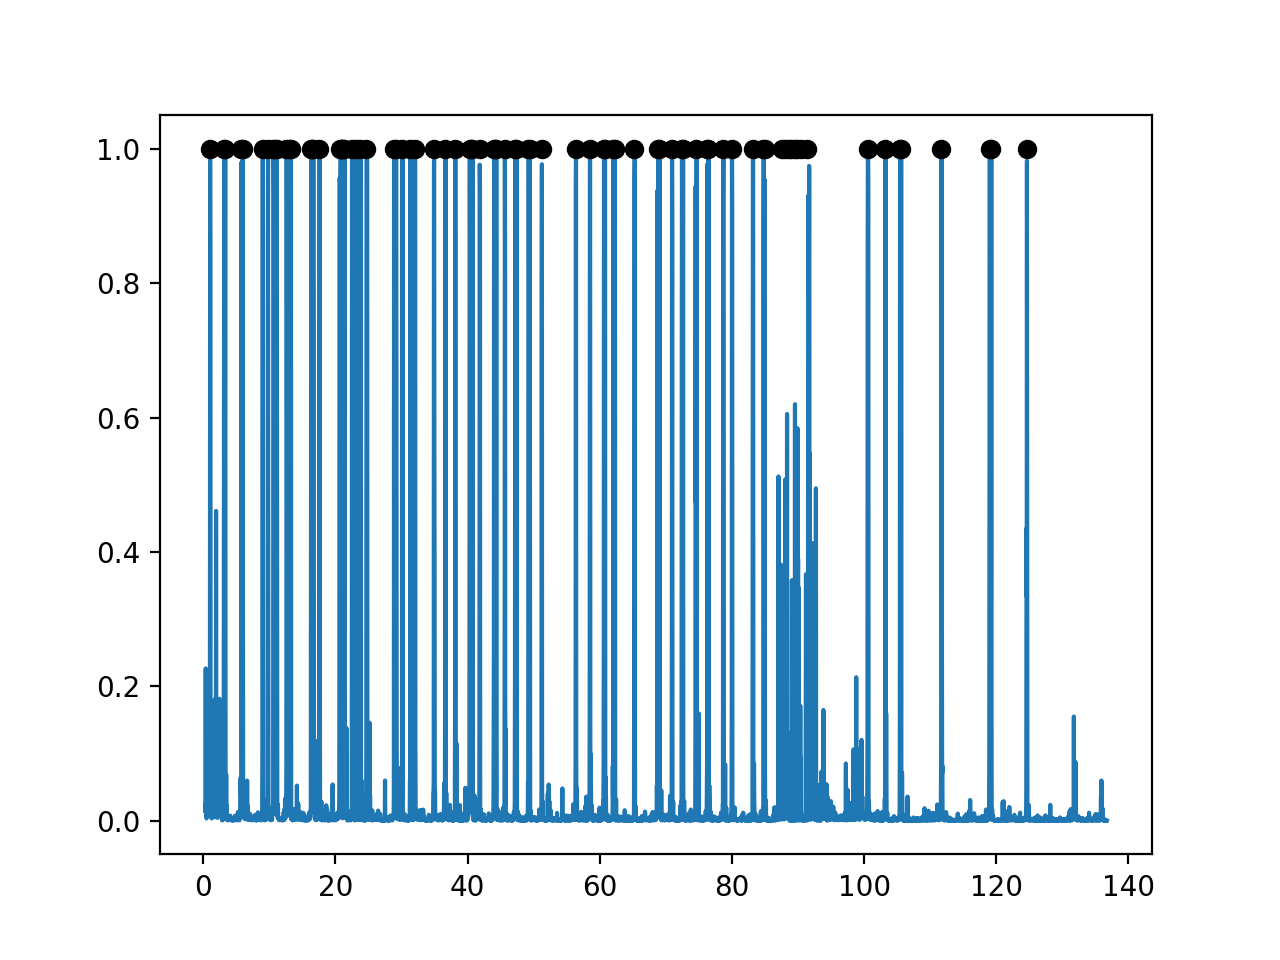

In [97]:
fig,ax=plt.subplots()
max_time = sync_data['cam1_exposure_rising'][4096]
ax.plot(sync_data['cam1_exposure_rising'][:4096],predictions['all_preds'][:,2])
ax.plot(licks.query('time <= @max_time'), np.ones_like(licks.query('time <= @max_time')), 'ok')

In [95]:
max_time = sync_data['cam1_exposure_rising'][4096]
licks.query('time <= @max_time')

,time
0,1.01708
1,3.14674
2,3.27260
3,5.77010
4,5.95047
5,8.97777
6,9.77713
7,10.59226
8,10.79162
9,11.10806
